# How to Define Extents

To restrict your API query to a certain area, you'll need to define an `Extent`. The `Extent` object is a polygon that can convert itself into the xml format needed by the API query. You can use an existing polygon to create your extent by specifying the coordinates yourself, or by using a polygon from another source, such as a shapefile. `Extent` also has three convienence methods to cover common extent types, which don't require you to already have a polygon:
 - Extent.from_bbox()
 - Extent.from_radius()
 - Extent.from_ons_code()


## Extent from Polygon
If you have a [Shapely polygon](https://shapely.readthedocs.io/en/stable/manual.html#polygons) that defines the area you would like to query within, you can pass this straight to `Extent`. This example shows how you can construct an extent to query the Features API for all the Zoomstack Local Buildings within a rectangle.

In [46]:
import os
from shapely.geometry import Polygon
from osdatahub import Extent
from osdatahub import FeaturesAPI 
os.environ['PROJ_NETWORK'] = 'OFF'

# Retrieve your OS Data Hub API key 
key = os.environ.get("OS_API_KEY")

# Define a rectangle by passing an ordered list of coordinate tuples.
SW = (435000, 114500)
SE = (437500, 114500)
NE = (437500, 116000)
NW = (435000, 116000)
rectangle = Polygon([SW, SE, NE, NW])

# You need to tell extent what type of coordinates you are using
# These are British National Grid, which uses EPSG code 27700
crs="EPSG:27700"

# Create the extent
polygon_extent = Extent(rectangle, crs=crs)

`Extent` stores its shapely polygon in the `.polygon` attribute, so we can plot it on a map to check it covers the area we wanted.

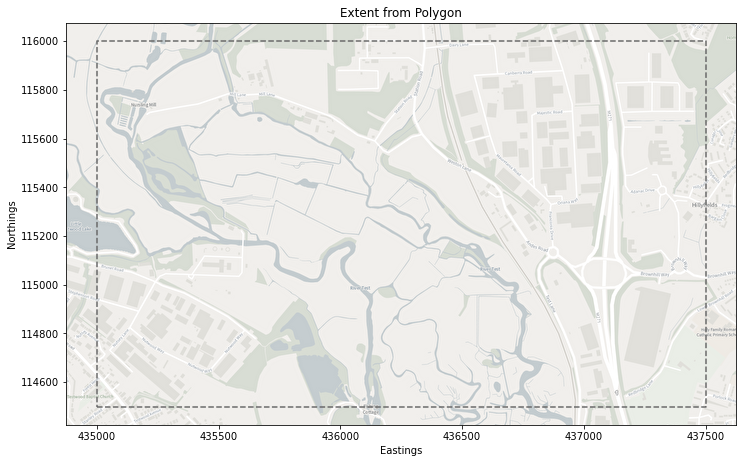

In [47]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt

# Shapely polygon of extent
polygon = polygon_extent.polygon

# Plot the extent
f, ax = plt.subplots(figsize=(12, 10))
ax.plot(*zip(*polygon.exterior.coords), color="dimgray", linestyle='--')
basemap_url = "https://api.os.uk/maps/raster/v1/zxy/Light_3857/{z}/{x}/{y}.png?key=" + key
ctx.add_basemap(ax, source=basemap_url, crs=crs, interpolation="sinc")
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")
ax.set_title("Extent from Polygon")
plt.show()

In [48]:
# The extent is then passed to the API to use in the query
features = FeaturesAPI(key, "zoomstack_local_buildings", polygon_extent)
# If you are querying a large area or a dense data product,
# you may need to increase the limit to get all the data
results = features.query(limit=10000)

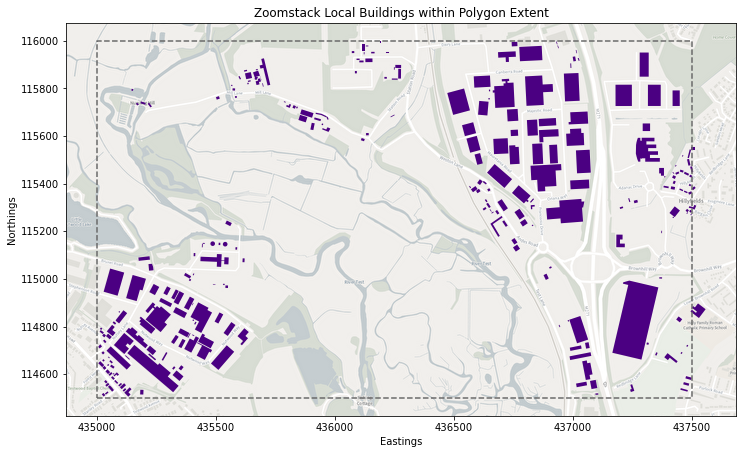

In [49]:
# Plot the results
results_gdf = gpd.GeoDataFrame.from_features(results['features'], crs=crs)
ax = results_gdf.plot(color="indigo", figsize=(12, 10))
ax.plot(*zip(*polygon.exterior.coords), color="dimgray", linestyle='--')
ctx.add_basemap(ax, source=basemap_url, crs=crs, interpolation="sinc")
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")
ax.set_title("Zoomstack Local Buildings within Polygon Extent")
plt.show()

## Extent from Bounding Box
If your extent is rectangular, instead of specifying all the coordinates and constructing a polygon, you can use the `Extent.from_bbox()` method, which only requires the coordinates of the South-West and North-East corners in the order (west, south, east, north). This results in the same `Extent` object as the previous example, just in fewer lines of code.

You might use this if you want to return data that covers area currently visible in a web map, or if you want to match the bounds of another data source, such as a raster, geodataframe or shapefile.

In [50]:
# Using the same coordinates as the previous example
west, south = 435000, 114500
east, north = 437500, 116000
bbox_extent = Extent.from_bbox((west, south, east, north), crs="EPSG:27700")

# Check that both approaches give the same result
print('Extents are equal:', polygon_extent == bbox_extent)

Extents are equal: True


## Extent from Radius
`Extent.from_radius()` is a convenient way to query for data within a certain distance of a point location. This method can only be used with `crs='EPSG:27700'` and `crs='EPSG:3857'`, which are projected coordinate systems and use units of meters. If you are using longitude and latitude, you will need to convert to one of the two supported projections first.

(See [Introduction to Coordinate Systems / Spatial Reference Systems](https://gsp.humboldt.edu/olm/Lessons/GIS/03%20Projections/IntroductionToCoordinateSystems1.html) to understand the differences between projected and geographic coordinate systems)

This example shows how you can query for all addresses within 200m of a point location.

In [51]:
from osdatahub import PlacesAPI

point = (441317, 112165)
distance = 200
radial_extent = Extent.from_radius(point, distance, crs="EPSG:27700")
places = PlacesAPI(key)
addresses = places.query(radial_extent, limit=10000)
print(f'There are {len(addresses["features"])} addresses within {distance}m of {point}.')

There are 235 addresses within 200m of (441317, 112165).


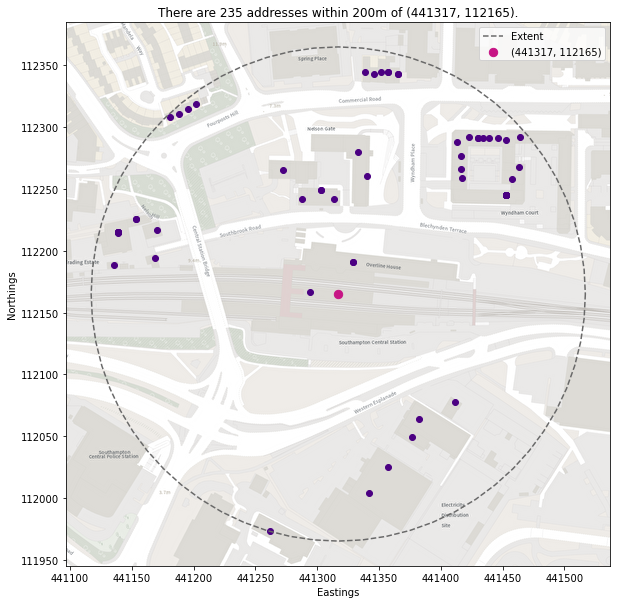

In [52]:
# Convert GeoJSON results to geodataframe for plotting
addresses_gdf = gpd.GeoDataFrame.from_features(addresses['features'], crs=crs)

# Plot the results
ax = addresses_gdf.plot(color="indigo", figsize=(12, 10))
ax.plot(*zip(*radial_extent.polygon.exterior.coords), color="dimgray", linestyle='--', label="Extent")
ax.scatter(*point, color="mediumvioletred", s=70, label=point)
ctx.add_basemap(ax, source=basemap_url, crs=crs, interpolation="sinc")
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")
ax.set_title(f'There are {len(addresses["features"])} addresses within {distance}m of {point}.')
plt.legend()
plt.show()

Notice that there looks like there are a lot less points on the map than the number of results suggested - this is because some addresses, such as those in blocks of flats, will share the same coordinates, but be at different heights.

## Extent from ONS Code
The Office for National Statistics maintains a source of official geographies for the UK, such as county boundaries, electoral wards, parishes, and census output areas. These boundaries are commonly used for data analysis, particularly of socio-economic factors. You can automatically define a query extent by using the ONS code for the particular area you are interested in, making it easy to combine geospatial information with other data sources, such as census records. A full list of available codes can be found [here](http://statistics.data.gov.uk/atlas/resource?uri=http://statistics.data.gov.uk/id/statistical-geography/K02000001). This example shows how you can find all the greenspace in a particular electoral ward.

In [62]:
# This is the ONS code for the Woolston electoral ward in Southampton.
ward = "E05002470"
electoral_extent = Extent.from_ons_code(ward)

# Note that you cannot set the crs when requesting an ONS geography
# The crs of the extent will always be EPSG:4326
print(electoral_extent.crs)

EPSG:4326


In [66]:
# Query the API
features = FeaturesAPI(key, "zoomstack_greenspace", electoral_extent)
results = features.query(limit=10000)

# Convert GeoJSON results to geodataframe for plotting
results_gdf = gpd.GeoDataFrame.from_features(results['features'], crs=electoral_extent.crs)
extent_gdf = gpd.GeoDataFrame({"geometry": [electoral_extent.polygon.exterior],
                               "ONS Code": [ward]},
                              crs=electoral_extent.crs)

Next we can plot the results, however the basemap has a crs of EPSG:3857 and the data has a crs of EPSG:4326, so we need to convert the data so it aligns correctly with the basemap first. We could choose to convert the basemap to match the data instead, but it results in quite a warped looking plot. 

In [67]:
results_gdf = results_gdf.to_crs("EPSG:3857")
extent_gdf = extent_gdf.to_crs("EPSG:3857")

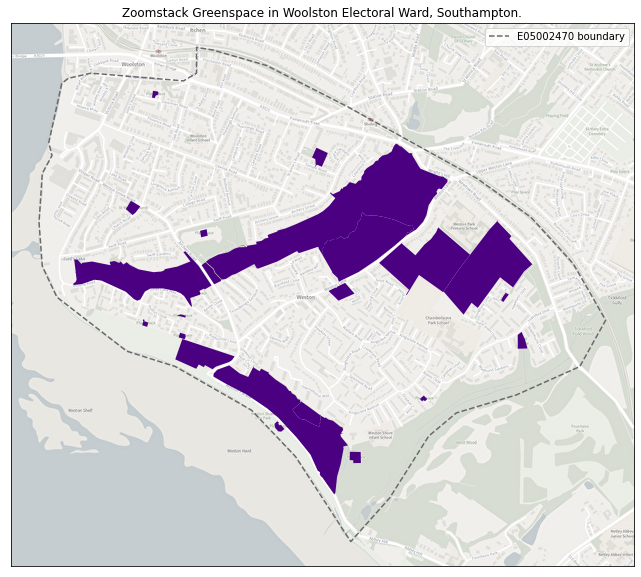

In [69]:
# Plot the results.
ax = results_gdf.plot(color="indigo", figsize=(12, 10))
extent_gdf.plot(ax=ax, edgecolor="dimgray", linestyle='--', label=f"{ward} boundary")
ctx.add_basemap(ax, source=basemap_url, interpolation="sinc")
ax.axes.xaxis.set_visible(False), ax.axes.yaxis.set_visible(False)
ax.set_title(f'Zoomstack Greenspace in Woolston Electoral Ward, Southampton.')
plt.legend()
plt.show()